### file import & dataset

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from tqdm import tqdm

from PIL import Image # 이미지 관련 라이브러리
import cv2

In [36]:
import warnings # 경고 제거
warnings.filterwarnings('ignore')

In [37]:
train_df = pd.read_csv('../data/train.csv')
meta_df = pd.read_csv('../data/meta.csv')

In [38]:
train_df.shape

(1570, 2)

In [39]:
train_df.head()

ID  target
0  002f99746285dfdd.jpg      16
1  008ccd231e1fea5d.jpg      10
2  008f5911bfda7695.jpg      10
3  009235e4c9c07af5.jpg       4
4  00b2f44967580c74.jpg      16

In [40]:
meta_df.head()

target                                         class_name
0       0                                     account_number
1       1  application_for_payment_of_pregnancy_medical_e...
2       2                                      car_dashboard
3       3            confirmation_of_admission_and_discharge
4       4                                          diagnosis

### data 확인

1. 파일 존재 및 일치 여부 확인

In [41]:
# 이미지 디렉토리 경로
image_dir = '../data/train'

# CSV에 기록된 파일명 set
csv_files = set(train_df['ID'])

# 실제 디렉토리에 존재하는 파일명 set
dir_files = set(os.listdir(image_dir))

# 누락된 파일
missing_files = csv_files - dir_files

# 추가된 파일
extra_files = dir_files - csv_files

print(f'CSV에 있지만 디렉토리에 없는 파일 개수: {len(missing_files)}')
print(f'디렉토리에 있지만 CSV에 없는 파일 개수: {len(extra_files)}')

CSV에 있지만 디렉토리에 없는 파일 개수: 0
디렉토리에 있지만 CSV에 없는 파일 개수: 0


2. 클래스 분포 확인

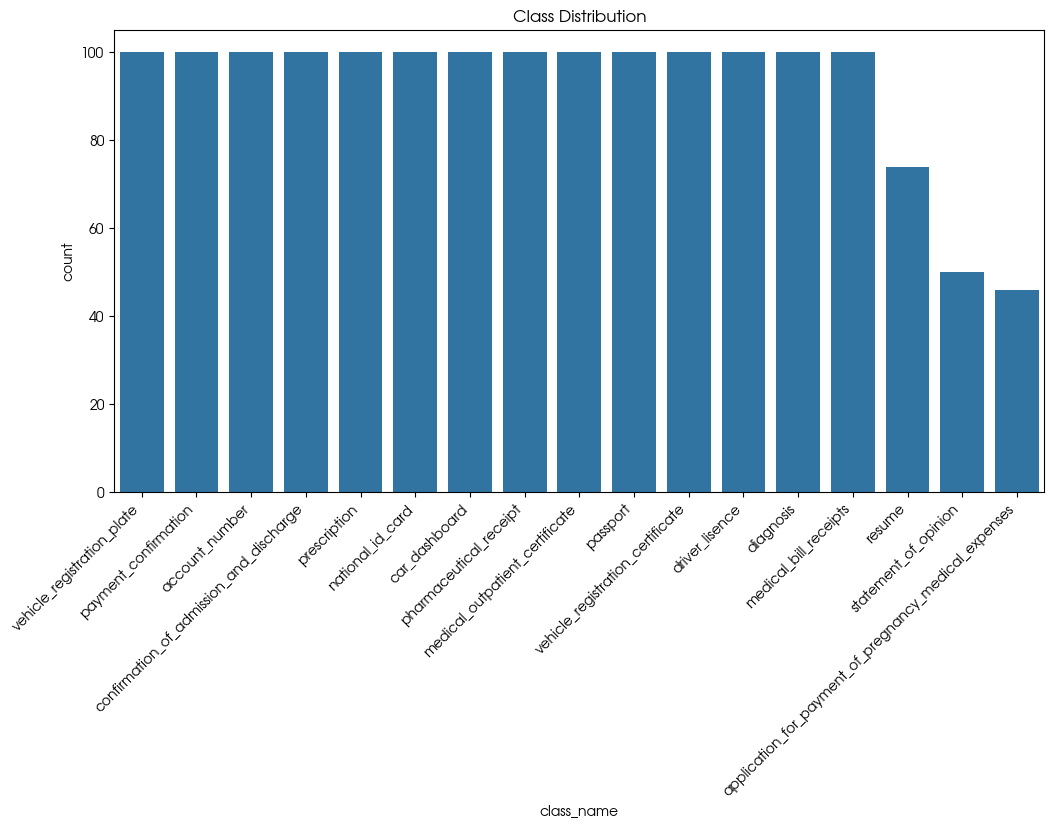

class_name
vehicle_registration_plate                               100
payment_confirmation                                     100
account_number                                           100
confirmation_of_admission_and_discharge                  100
prescription                                             100
national_id_card                                         100
car_dashboard                                            100
pharmaceutical_receipt                                   100
medical_outpatient_certificate                           100
passport                                                 100
vehicle_registration_certificate                         100
driver_lisence                                           100
diagnosis                                                100
medical_bill_receipts                                    100
resume                                                    74
statement_of_opinion                                      50
application_f

In [45]:
# meta_df와 merge
train_df = train_df.merge(meta_df, on='target', how='left')

plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='class_name', order=train_df['class_name'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution')
plt.show()

# 클래스별 개수 출력
print(train_df['class_name'].value_counts())

3. 해상도 및 비율 확인

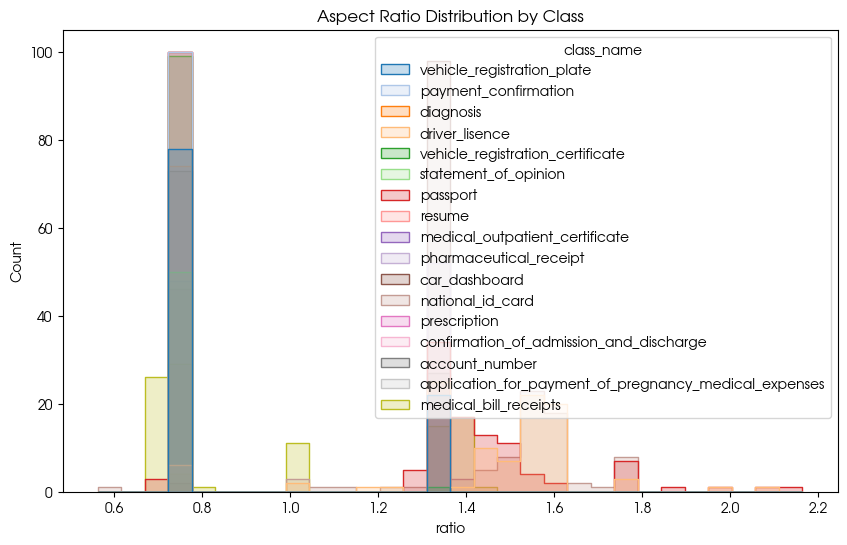

In [55]:
# 해상도, 비율 저장용 리스트
widths, heights, ratios, classes = [], [], [], []

for idx, row in train_df.iterrows():
    img_path = os.path.join(image_dir, row['ID'])
    img = Image.open(img_path)
    w, h = img.size
    widths.append(w)
    heights.append(h)
    ratios.append(w / h)
    classes.append(row['class_name'])

# 새로운 데이터프레임
size_df = pd.DataFrame({
    'class_name': classes,
    'width': widths,
    'height': heights,
    'ratio': ratios
})

# 비율 히스토그램
plt.figure(figsize=(10, 6))
sns.histplot(data=size_df, x='ratio', hue='class_name', element='step', common_norm=False, palette='tab20', bins=30)
plt.title('Aspect Ratio Distribution by Class')
plt.show()

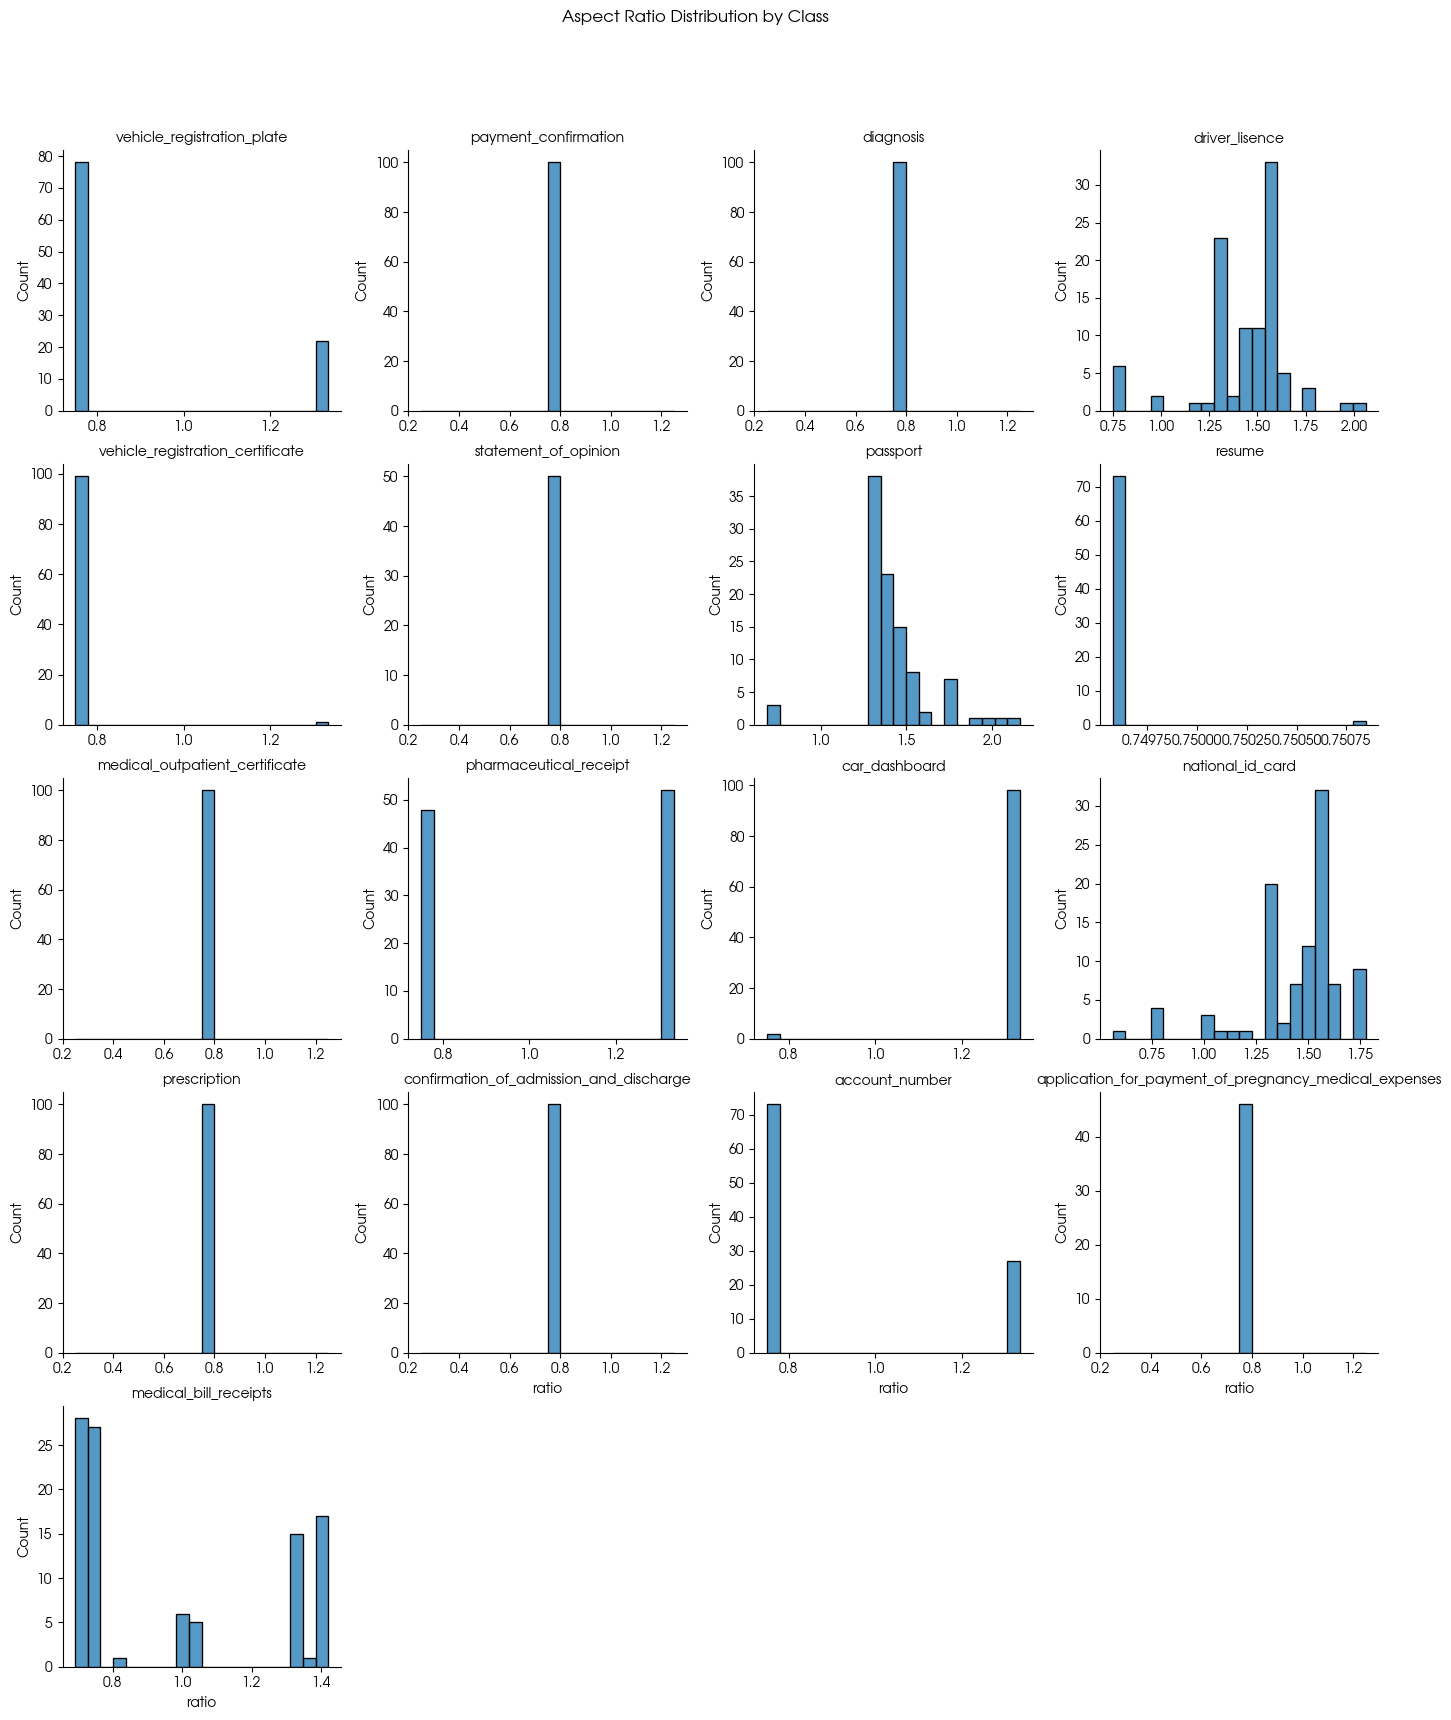

In [56]:
g = sns.FacetGrid(size_df, col='class_name', col_wrap=4, sharex=False, sharey=False, height=3.5)
g.map_dataframe(sns.histplot, x='ratio', bins=20)
g.set_titles('{col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Aspect Ratio Distribution by Class')
plt.show()

4. 밝기/대비(픽셀 intensity) 분포

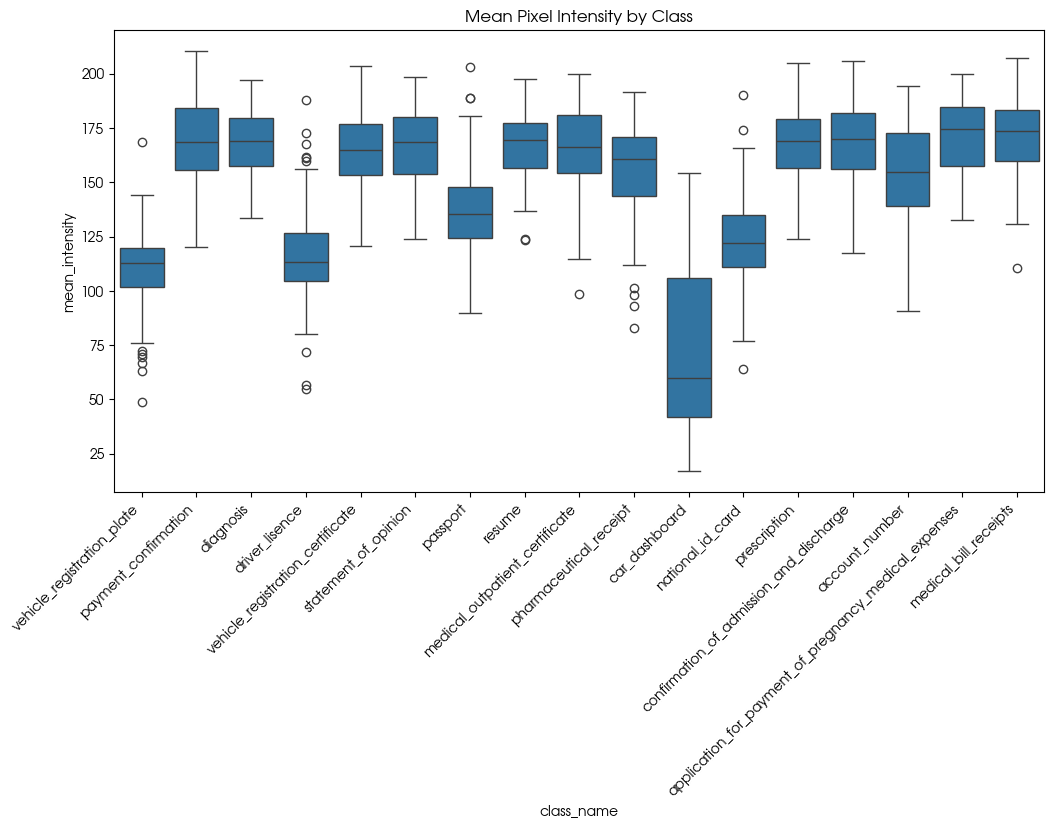

In [57]:
mean_intensities = []
class_names = []

for idx, row in train_df.iterrows():
    img_path = os.path.join(image_dir, row['ID'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        mean_intensities.append(np.mean(img))
        class_names.append(row['class_name'])

intensity_df = pd.DataFrame({
    'class_name': class_names,
    'mean_intensity': mean_intensities
})

plt.figure(figsize=(12, 6))
sns.boxplot(data=intensity_df, x='class_name', y='mean_intensity')
plt.xticks(rotation=45, ha='right')
plt.title('Mean Pixel Intensity by Class')
plt.show()

4-1. 마스킹 여부 확인

In [62]:
def check_mask_ratio(image_path, dark_thresh=10, bright_thresh=245):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None, None

    total_pixels = img.size
    dark_pixels = np.sum(img < dark_thresh)
    bright_pixels = np.sum(img > bright_thresh)

    dark_ratio = dark_pixels / total_pixels
    bright_ratio = bright_pixels / total_pixels

    return dark_ratio, bright_ratio

# 클래스별 평균 마스킹 비율 확인
class_mask_stats = []

for class_name in train_df['class_name'].unique():
    subset = train_df[train_df['class_name'] == class_name]
    dark_ratios, bright_ratios = [], []

    for idx, row in subset.iterrows():
        img_path = os.path.join(image_dir, row['ID'])
        dark_ratio, bright_ratio = check_mask_ratio(img_path)
        if dark_ratio is not None:
            dark_ratios.append(dark_ratio)
            bright_ratios.append(bright_ratio)

    avg_dark = np.mean(dark_ratios)
    avg_bright = np.mean(bright_ratios)

    class_mask_stats.append({
        'class_name': class_name,
        'avg_dark_ratio': avg_dark,
        'avg_bright_ratio': avg_bright
    })

mask_df = pd.DataFrame(class_mask_stats)
print(mask_df)

                                           class_name  avg_dark_ratio  \
0                          vehicle_registration_plate        0.024959   
1                                payment_confirmation        0.009975   
2                                           diagnosis        0.022602   
3                                      driver_lisence        0.248042   
4                    vehicle_registration_certificate        0.020629   
5                                statement_of_opinion        0.019500   
6                                            passport        0.190958   
7                                              resume        0.028810   
8                      medical_outpatient_certificate        0.021220   
9                              pharmaceutical_receipt        0.015627   
10                                      car_dashboard        0.111056   
11                                   national_id_card        0.217436   
12                                       prescripti

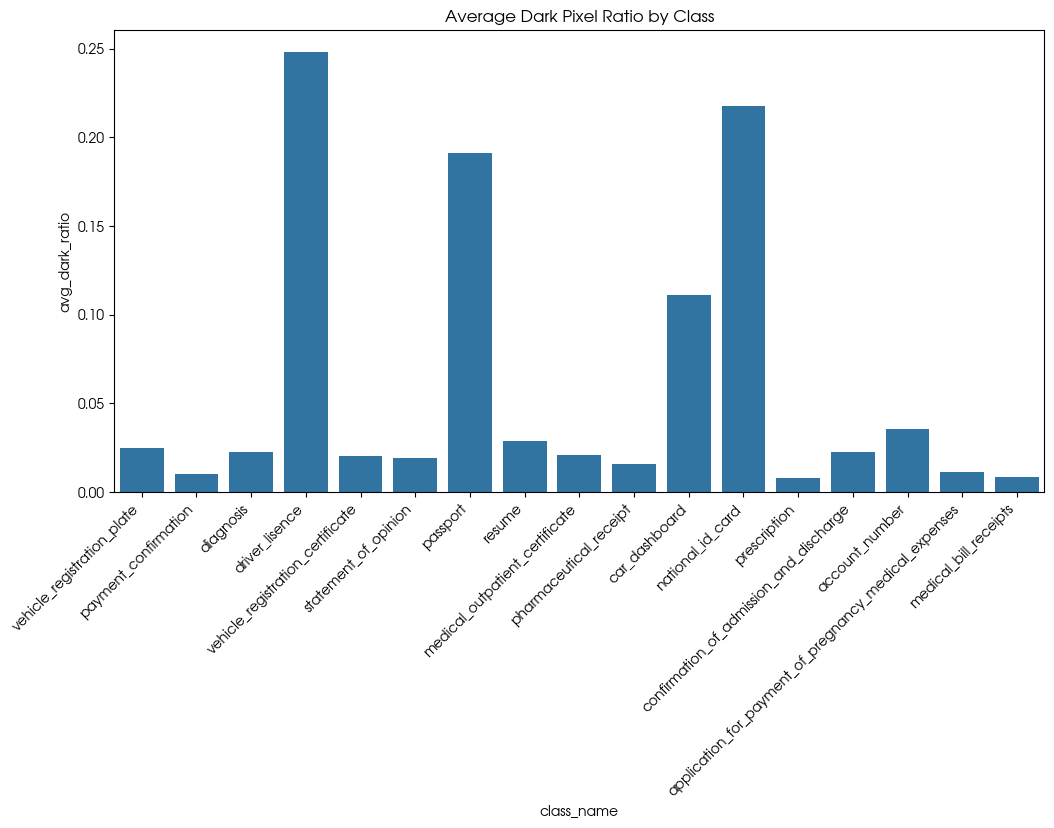

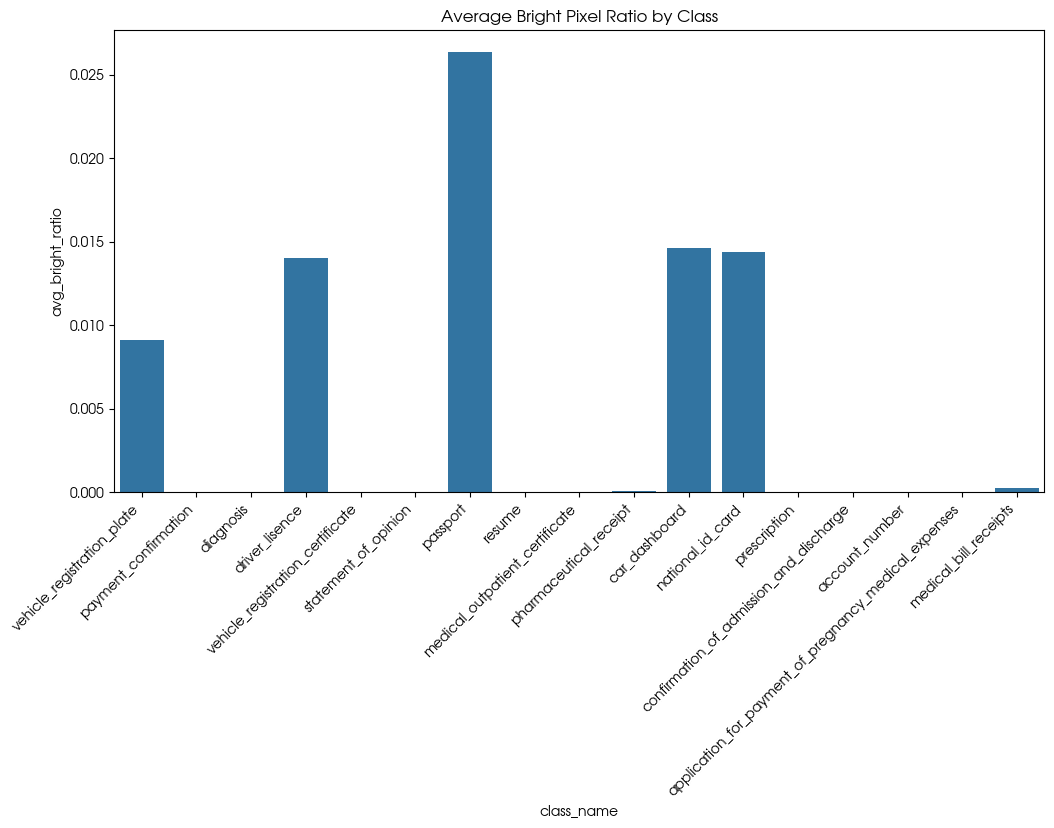

In [63]:
# dark
plt.figure(figsize=(12, 6))
sns.barplot(data=mask_df, x='class_name', y='avg_dark_ratio')
plt.xticks(rotation=45, ha='right')
plt.title('Average Dark Pixel Ratio by Class')
plt.show()

# bright
plt.figure(figsize=(12, 6))
sns.barplot(data=mask_df, x='class_name', y='avg_bright_ratio')
plt.xticks(rotation=45, ha='right')
plt.title('Average Bright Pixel Ratio by Class')
plt.show()

In [ ]:
# Dataset 정의
trn_dataset = ImageDataset(
    f"{data_path}/train.csv",
    f"{data_path}/train/",
    transform=trn_transform
)
tst_dataset = ImageDataset(
    f"{data_path}/sample_submission.csv",
    f"{data_path}/test/",
    transform=tst_transform
)
print(len(trn_dataset), len(tst_dataset))

1570 3140


5. 흑백 / 컬러 비율

In [65]:
# 경로 설정
train_img_dir = "../data/train"

In [66]:
bw_count = 0
color_count = 0

for img_name in train_df['ID']:
    img_path = os.path.join(train_img_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    if img is None:
        continue

    # 채널 분리
    b, g, r = cv2.split(img)
    
    # 모든 픽셀이 동일하면 흑백
    if (b == g).all() and (b == r).all():
        bw_count += 1
    else:
        color_count += 1

total = bw_count + color_count

print(f"총 이미지 수: {total}")
print(f"흑백 이미지 수: {bw_count} ({bw_count / total * 100:.2f}%)")
print(f"컬러 이미지 수: {color_count} ({color_count / total * 100:.2f}%)")

총 이미지 수: 1570
흑백 이미지 수: 0 (0.00%)
컬러 이미지 수: 1570 (100.00%)


6. 클래스별 샘플 이미지 시각화

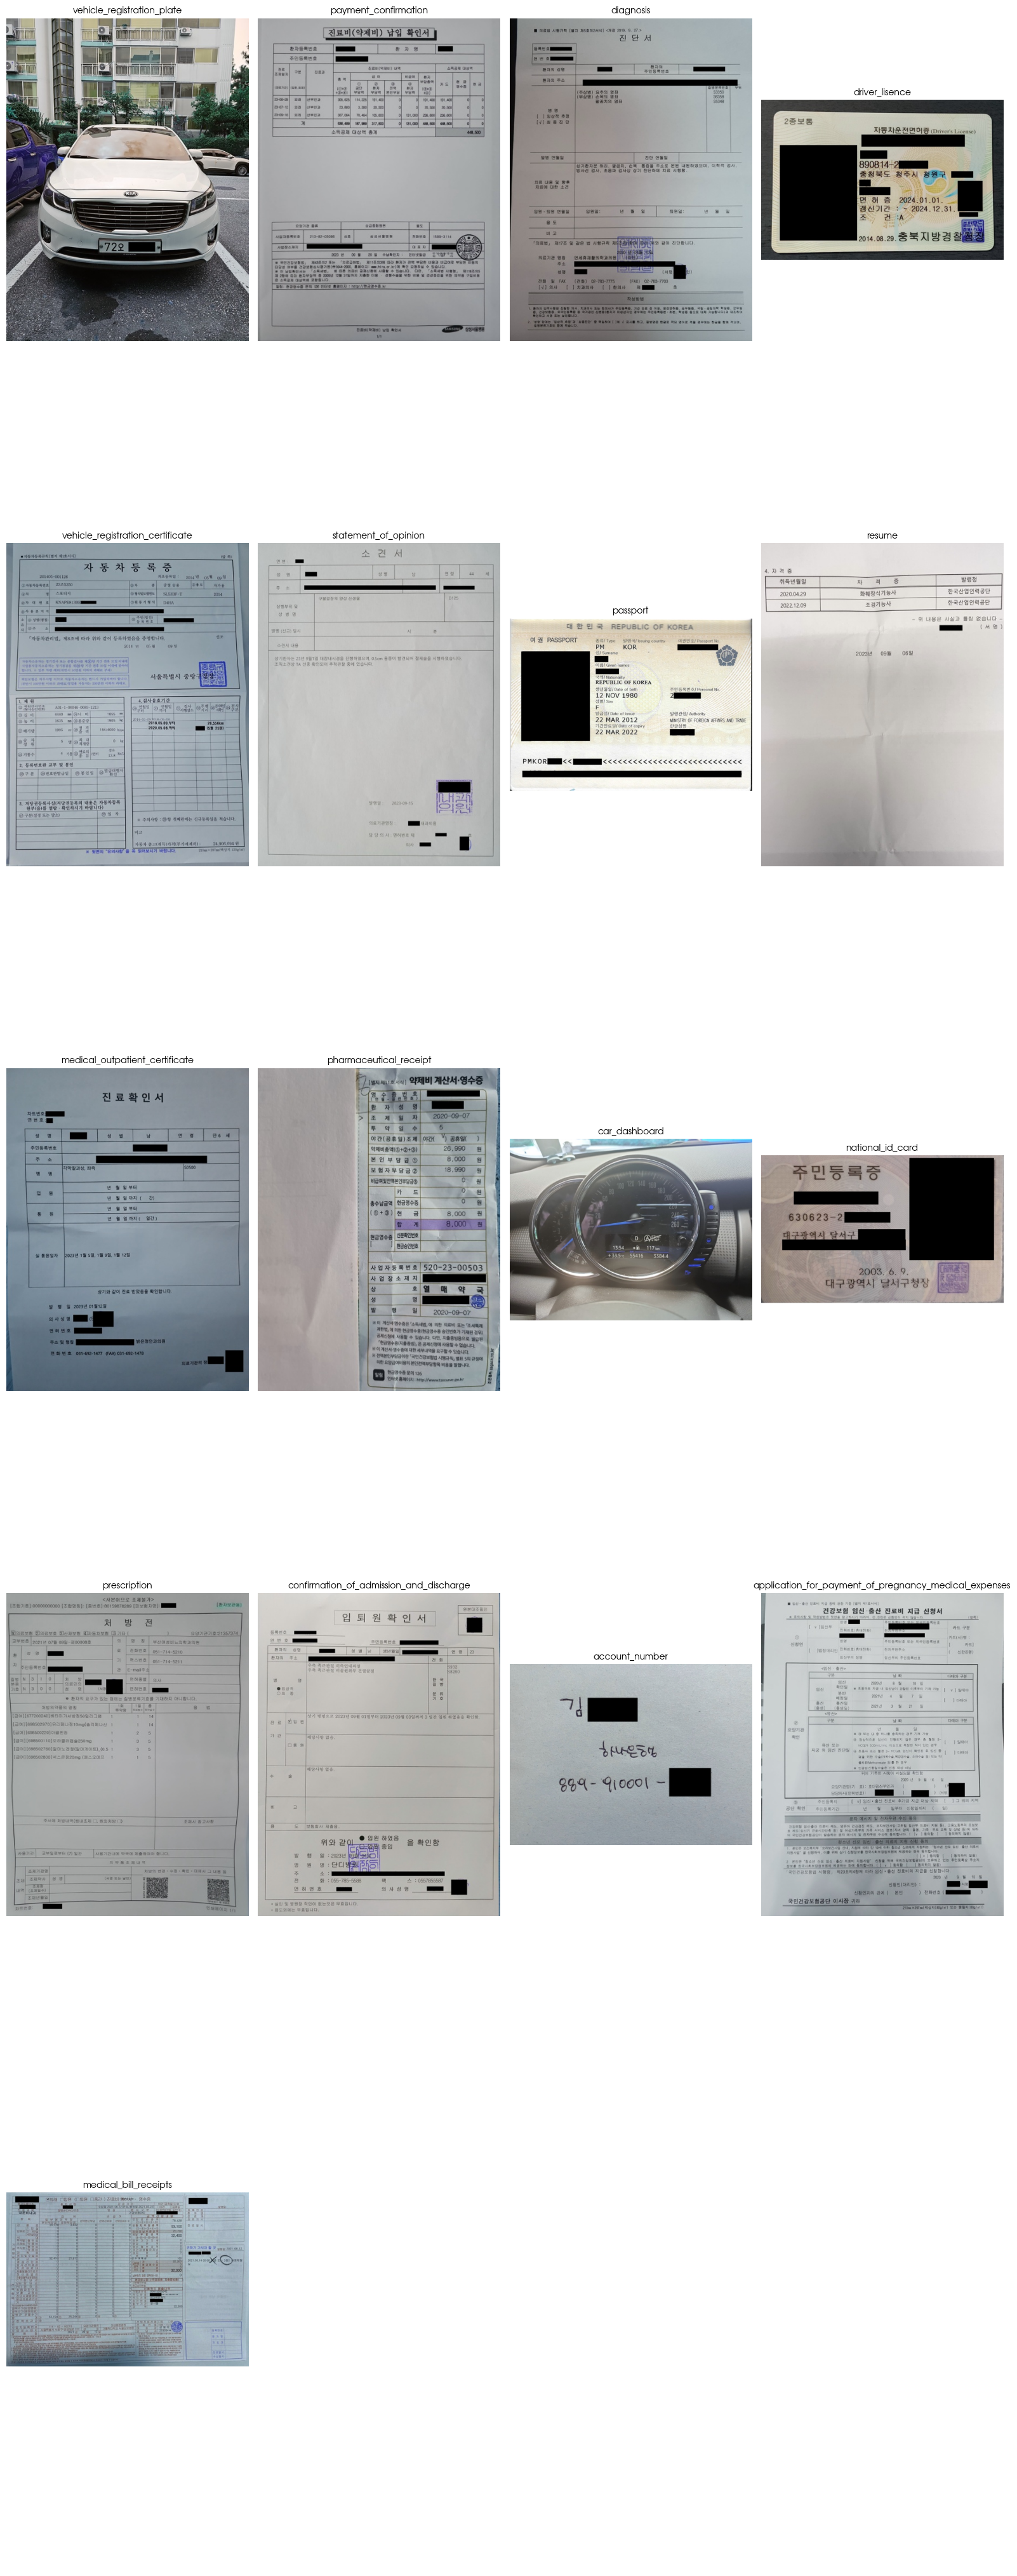

In [60]:
# 클래스 리스트
class_list = train_df['class_name'].unique()

# 클래스별 첫 번째 이미지 1장씩 출력
num_classes = len(class_list)
fig, axs = plt.subplots(nrows=num_classes // 4 + 1, ncols=4, figsize=(16, num_classes * 2.5))

for i, class_name in enumerate(class_list):
    ax = axs[i // 4, i % 4]
    sample = train_df[train_df['class_name'] == class_name].iloc[0]
    img_path = os.path.join(image_dir, sample['ID'])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(class_name, fontsize=10)

# 불필요한 subplot 제거
for j in range(i+1, axs.size):
    axs[j // 4, j % 4].axis('off')

plt.tight_layout()
plt.show()